In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch, torch.nn as nn
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as compare_psnr


%matplotlib inline

In [2]:
# setup
torch.manual_seed(0)
plt.rcParams['toolbar'] = 'none'
plt.ion() # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


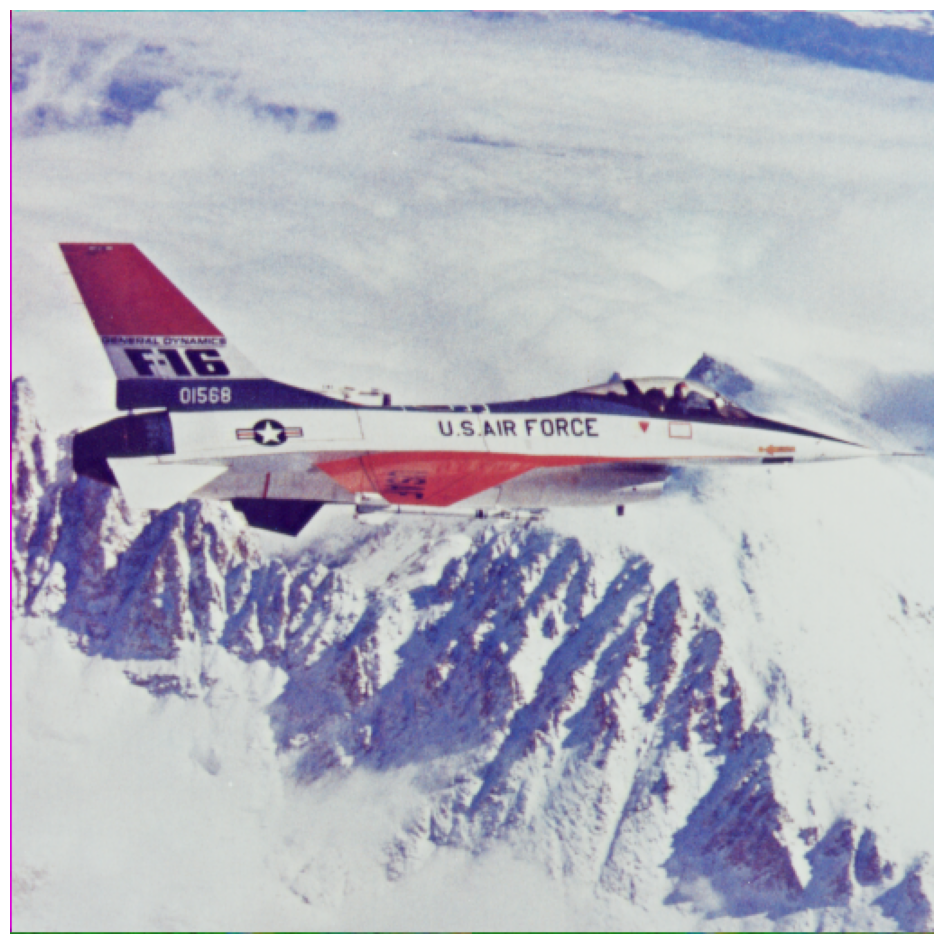

In [3]:
nxd = 512  # pixels in x dimension
img = cv2.imread('/kaggle/input/images/F16_GT.png')
img = cv2.resize(src=img, dsize=(nxd, nxd), interpolation=cv2.INTER_CUBIC)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig1, axis1 = plt.subplots(1, 1, figsize=(20,12))
axis1.imshow(img)
axis1.set_axis_off()

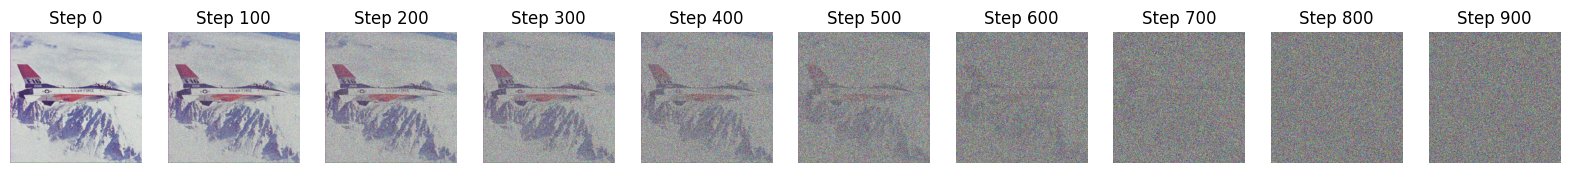

In [4]:
def forward_diffusion(x0, num_steps, beta_start, beta_end):
    betas = np.linspace(beta_start, beta_end, num_steps)
    alphas = 1 - betas
    alphas_cumprod = np.cumprod(alphas)
    
    x_t = []
    x_t.append(x0)
    for t in range(1, num_steps + 1):
        noise = np.random.randint(x0.min(), x0.max(), size=x0.shape)
        alpha_t = alphas_cumprod[t-1]
        x_t_prev = x_t[-1]
        x_t_current = np.sqrt(alpha_t) * x0 + np.sqrt(1 - alpha_t) * noise
        x_t.append(x_t_current)
    
    output = np.array(x_t)[100::10]
    for i in range(len(output)):
        img_array = output[i]
        img_array = (img_array - img_array.min()) / (img_array.max() - img_array.min())  # Normalize to [0, 1]
        output[i] = img_array
    
    return output, alphas_cumprod

def plot_images(x_t, indices):
    num_images = len(indices)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 12))
    for ax, idx in zip(axes, indices):
        ax.imshow(x_t[idx])
        ax.set_title(f'Step {idx*10}')
        ax.axis('off')
    plt.show()

x0 = img
num_steps = 1000
beta_start = 0.0001
beta_end = 0.02

x_t, alphas_cumprod = forward_diffusion(x0, num_steps, beta_start, beta_end)

# Plot specific time steps
plot_images(x_t, indices=[i for i in range(0, 100, 10)])

In [5]:
# setup cnn class
class CNN(nn.Module):
    def __init__(self, n_layer, n_channel, kernel_size):
        super(CNN, self).__init__()
        pd = int(kernel_size/2)
        layers = [nn.Conv2d(3, n_channel, kernel_size, padding=pd), nn.PReLU(),]
        for _ in range(n_layer):
            layers.append(nn.Conv2d(n_channel, n_channel, kernel_size, padding=pd))
            layers.append(nn.BatchNorm2d(n_channel)) # normalize
            layers.append(nn.PReLU())
        layers.append(nn.Conv2d(n_channel, 3, kernel_size, padding=pd))
        
        self.deep_net = nn.Sequential(*layers)
        
    def forward(self, x):
        x = x.permute(2, 0, 1)
        return torch.squeeze(self.deep_net(x.unsqueeze(0)))
    
cnn = CNN(32, 64, 3).to(device)

Text(0.5, 1.0, 'z image 512 x 512')

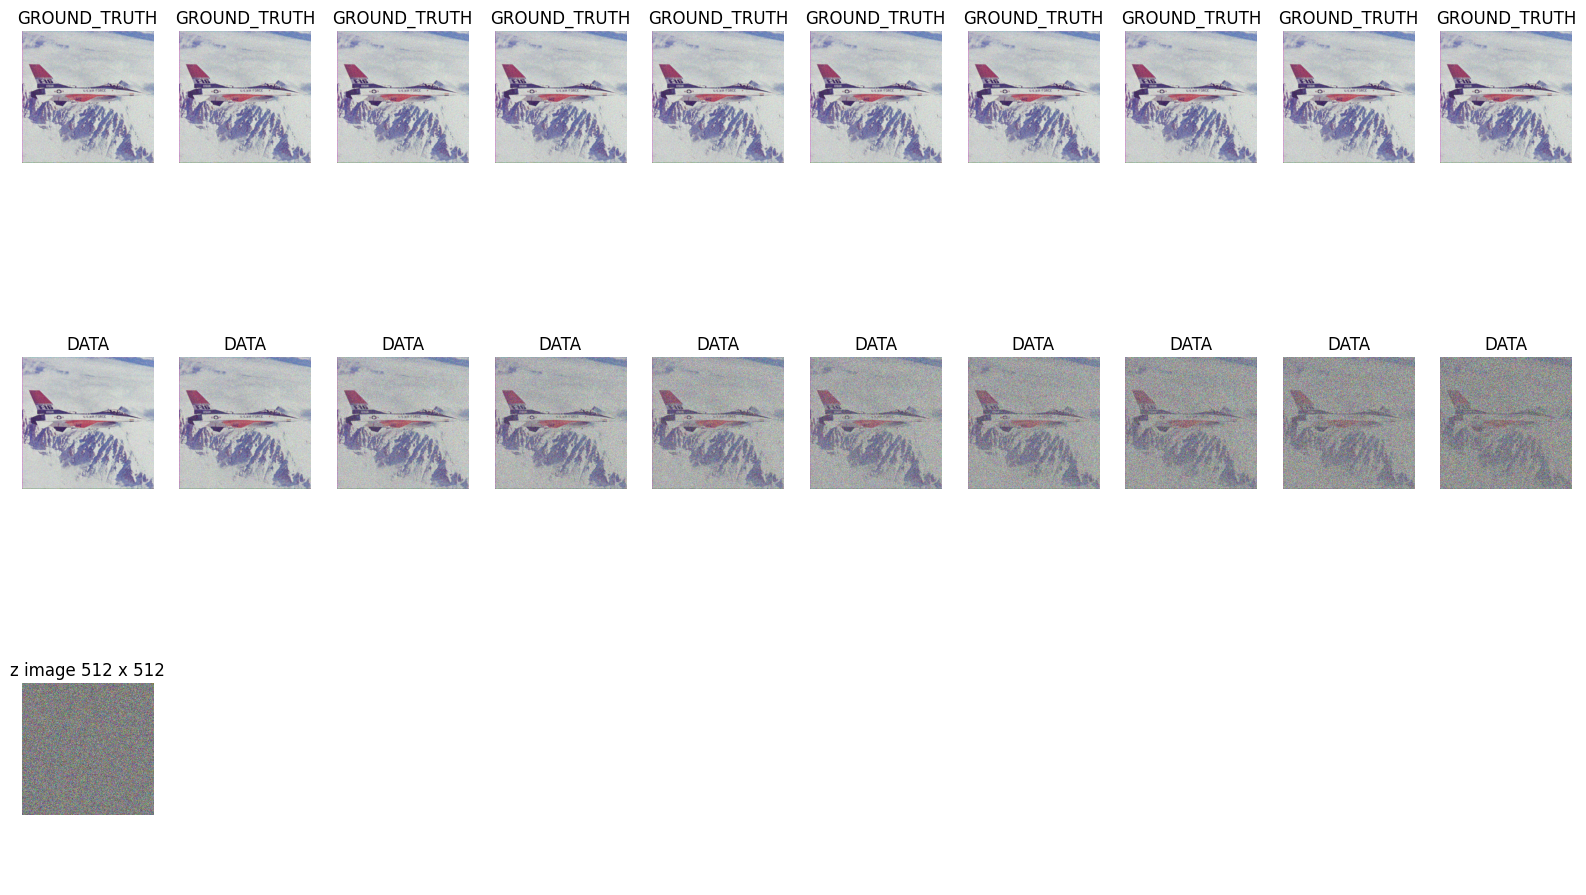

In [6]:
# input image is pure noise
input_image = torch.rand(nxd, nxd, 3).to(device)  

def torch_to_numpy(torch_array):
    return np.squeeze(torch_array.detach().cpu().numpy())
def numpy_to_torch(numpy_array):
    return torch.from_numpy(numpy_array).float()

true_object_torch = numpy_to_torch(img).to(device)
measured_data = torch.poisson(true_object_torch)

fig2, axis2 = plt.subplots(3, 10, figsize=(20,12))
for i in range(10):
    axis2[0,i].imshow(x_t[1])
    axis2[0,i].set_title('GROUND_TRUTH')
    axis2[0,i].set_axis_off()
    axis2[1,i].imshow(x_t[i*5])
    axis2[1,i].set_title('DATA')
    axis2[1,i].set_axis_off()
    axis2[2,i].set_axis_off()

axis2[2,0].imshow(torch_to_numpy(input_image))
axis2[2,0].set_title('z image %d x %d' %(nxd, nxd))


In [7]:
# initialize training things
optimiser = torch.optim.Adam(cnn.parameters(), lr=1e-4)
train_loss = list()
psnr_list = list()

output_images = []
output_psnr = []

In [8]:
mse_fn = nn.MSELoss().to(device)

# training process
for ind in range(len(x_t)-1, 1, -1):
    for ep in tqdm(range(30)):
        optimiser.zero_grad()
        output_image = cnn(input_image)
        output_image = output_image.squeeze(0).permute(1, 2, 0)
        loss = mse_fn(numpy_to_torch(x_t[ind]).to(device), output_image)
    
        train_loss.append(loss.item())
        loss.backward() # find gradients
        optimiser.step() # does the update

        psnr = compare_psnr(torch_to_numpy(output_image), x_t[1], data_range=x_t[1].max())
        
        psnr_list.append(psnr.item())
        
    print(loss.item())
    output_images.append(output_image)
    output_psnr.append(psnr)

100%|██████████| 30/30 [00:18<00:00,  1.66it/s]


0.07073676586151123


100%|██████████| 30/30 [00:17<00:00,  1.71it/s]


0.05892346426844597


100%|██████████| 30/30 [00:17<00:00,  1.68it/s]


0.05579245090484619


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.0544738695025444


100%|██████████| 30/30 [00:17<00:00,  1.73it/s]


0.05418982356786728


100%|██████████| 30/30 [00:17<00:00,  1.73it/s]


0.05360870808362961


100%|██████████| 30/30 [00:17<00:00,  1.71it/s]


0.05337154120206833


100%|██████████| 30/30 [00:17<00:00,  1.71it/s]


0.052790652960538864


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.05255739390850067


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.052329957485198975


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.05193194001913071


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.052618976682424545


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.05195551738142967


100%|██████████| 30/30 [00:17<00:00,  1.71it/s]


0.052150316536426544


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.05230399966239929


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.052097927778959274


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.052800342440605164


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.05388667434453964


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.0545416884124279


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.05456845089793205


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.054233402013778687


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.05375763773918152


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.05324529856443405


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.052953414618968964


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.05283647030591965


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.05232483893632889


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.052030619233846664


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.05136973783373833


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.05069621652364731


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.05026380717754364


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.04929720610380173


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.04826490581035614


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.047688841819763184


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.04701955243945122


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.04637157917022705


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.046129241585731506


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.04589187726378441


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.04535656422376633


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.04462677240371704


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.04345428943634033


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.04443901404738426


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.04404601454734802


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.0439387783408165


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.04270867258310318


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.041462235152721405


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.04080908000469208


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.039570264518260956


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.038772616535425186


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.037966564297676086


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.03651866689324379


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.03570667654275894


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.034946948289871216


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.034015920013189316


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.03369312733411789


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.03188406303524971


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.03116806596517563


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.030178209766745567


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.02902238629758358


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.028723087161779404


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.02804599329829216


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.026763519272208214


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.026064148172736168


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.024922078475356102


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.02449609898030758


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.023757880553603172


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.02268439158797264


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.021834753453731537


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.020993828773498535


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.01985762268304825


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.01944234035909176


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.018527377396821976


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.017693940550088882


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.017197415232658386


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.01622932404279709


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.015181551687419415


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.01447018887847662


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.013894995674490929


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.013295906595885754


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.012442819774150848


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.01148136705160141


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.010808050632476807


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.010376614518463612


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.009561961516737938


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.008759386837482452


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.008122971281409264


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.007445232477039099


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.006720786914229393


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


0.006286523770540953


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]

0.005564452614635229


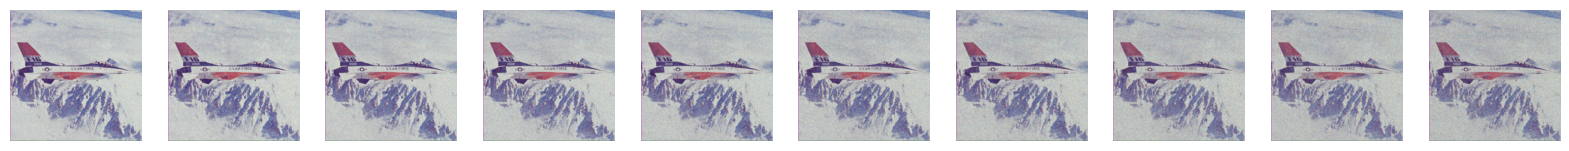

In [9]:
fig1, axis1 = plt.subplots(1, 10, figsize=(20,12))

for i in range(1, 11):
    axis1[i-1].set_axis_off()
    axis1[i-1].imshow(torch_to_numpy(output_images[i*-1]))

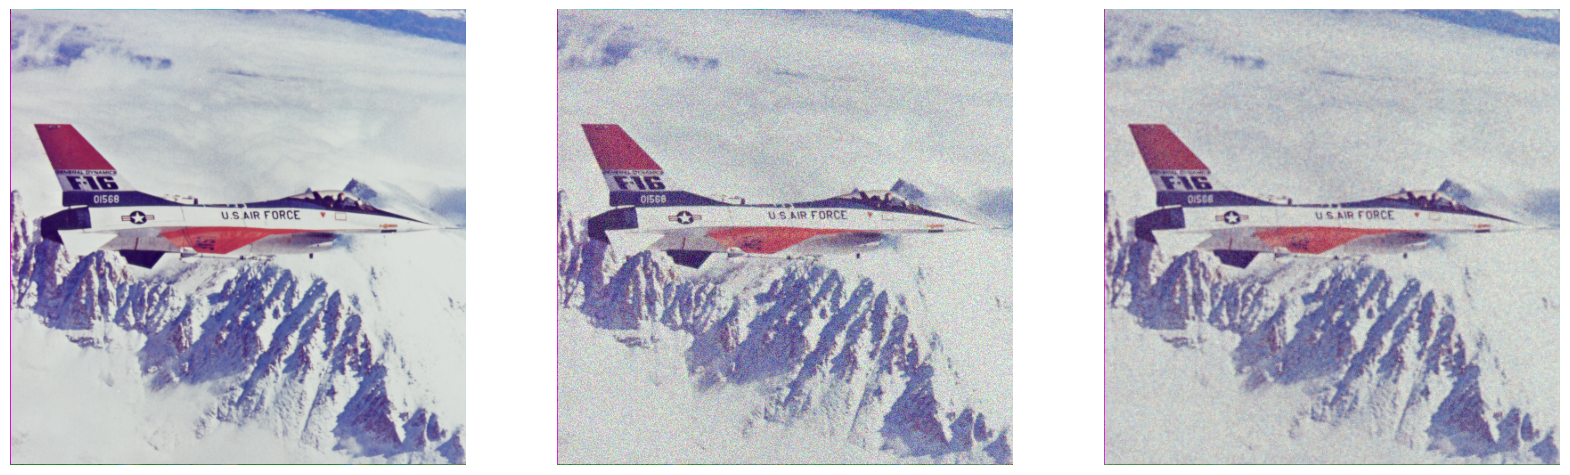

In [10]:
fig1, axis1 = plt.subplots(1, 3, figsize=(20,12))
axis1[0].imshow(img)
axis1[0].set_axis_off()
axis1[1].imshow(x_t[1])
axis1[1].set_axis_off()
axis1[2].imshow(torch_to_numpy(output_images[-1]))
axis1[2].set_axis_off()

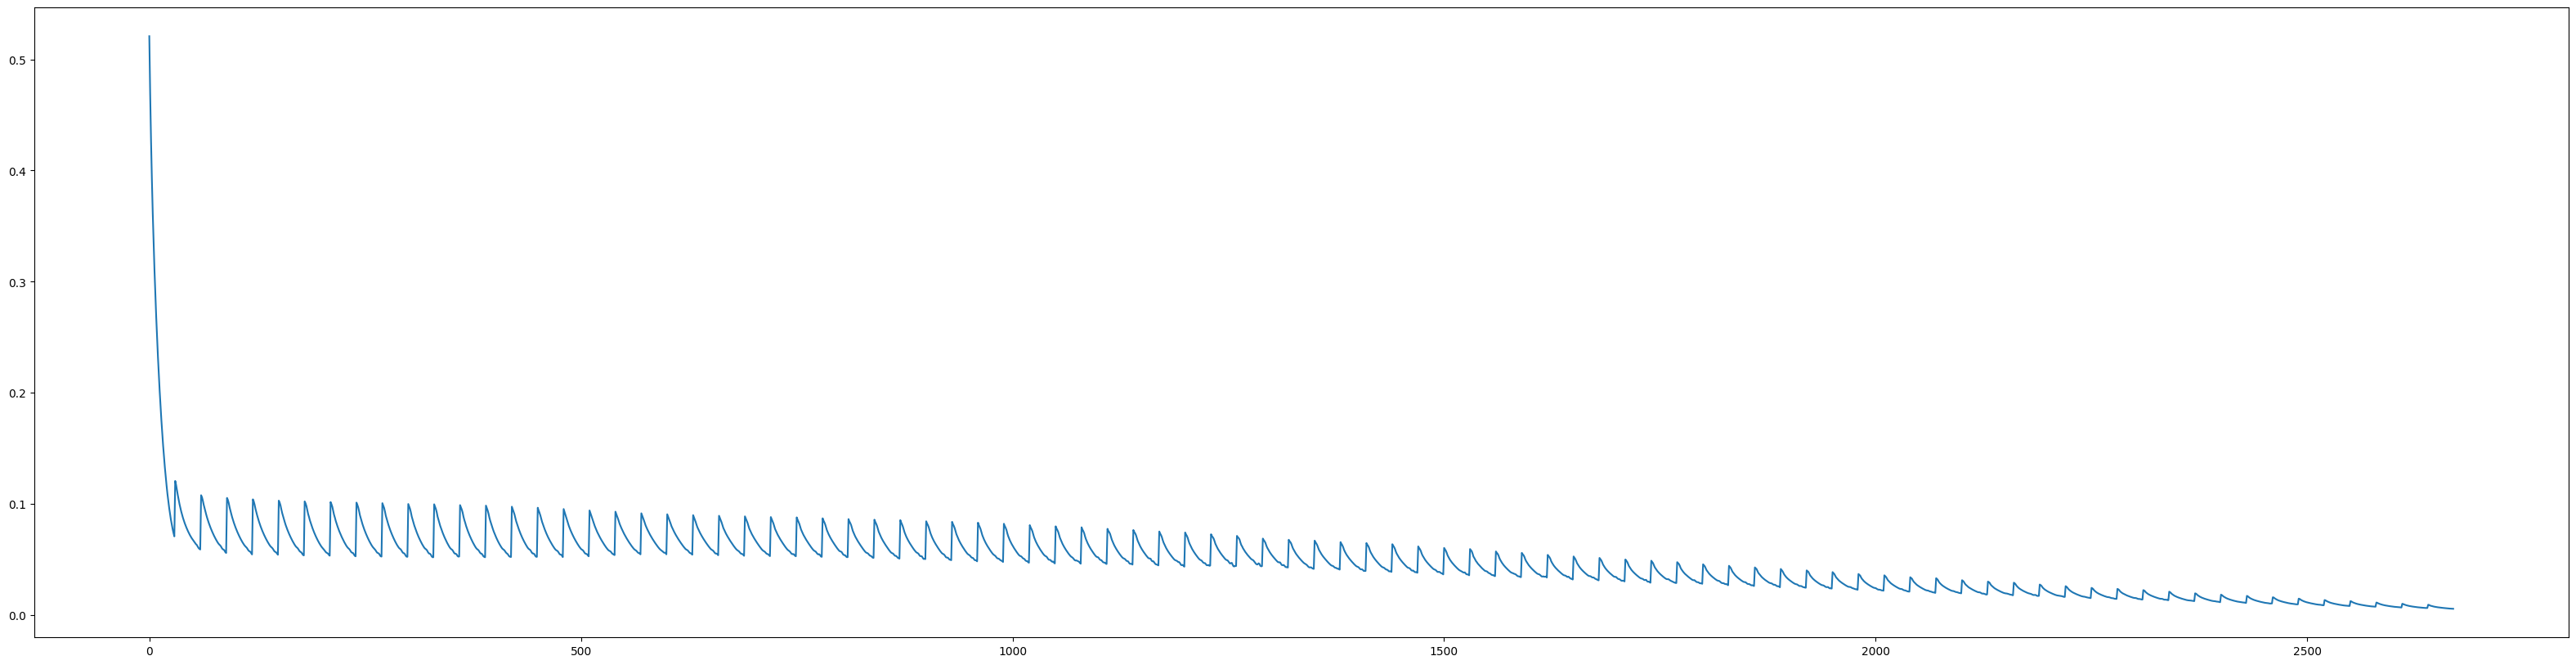

In [11]:
fig1, axis1 = plt.subplots(1, 1, figsize=(40, 10))
axis1.plot(train_loss)


20.994498419747146


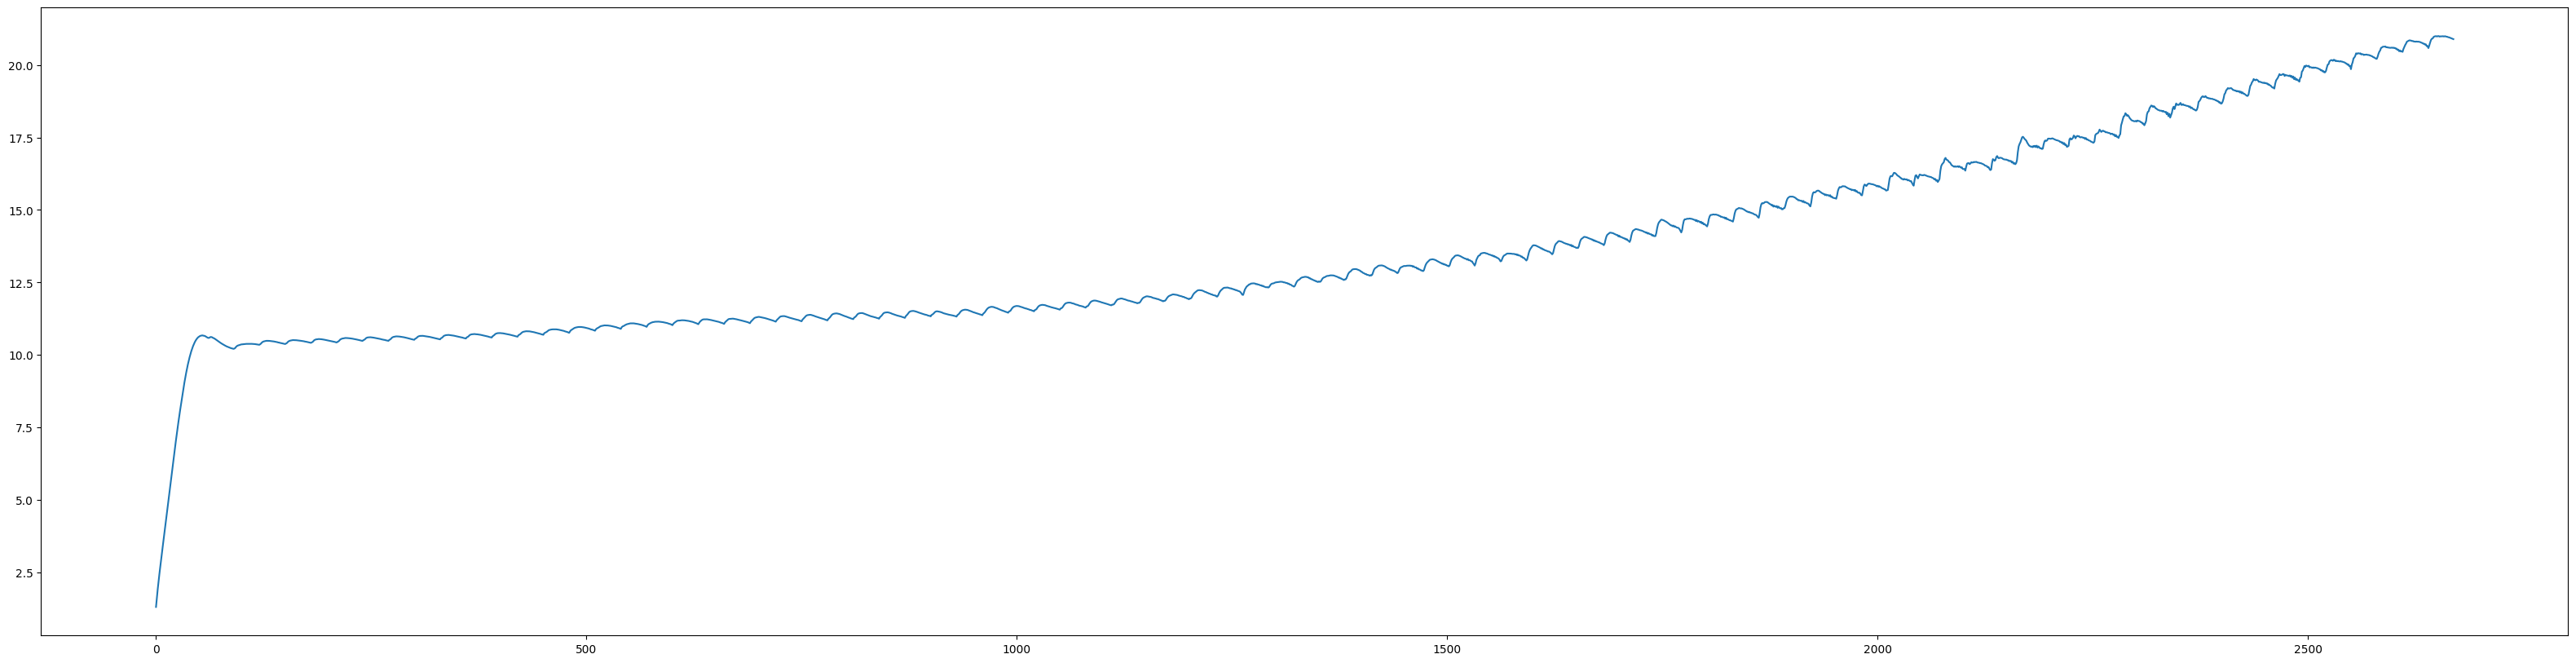

In [12]:
fig1, axis1 = plt.subplots(1, 1, figsize=(40, 10))
axis1.plot(psnr_list)
print(max(psnr_list))